# i. Imports and load the data 

In [1]:
import re
from pathlib import Path
import os

from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import nfl_data_py as nfl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

n_cores = os.cpu_count()

In [2]:
train_data_path = Path('../data/processed/field_goal_data.parquet')
fg_attempts = (
    pd.read_parquet(train_data_path)
    .assign(
        iced_kicker=lambda x: x['iced_kicker'].astype(int)
    )
)
fg_attempts.head()

,season,week,game_id,play_id,game_date,start_time,time_of_day,qtr,quarter_seconds_remaining,game_seconds_remaining,stadium,stadium_id,is_home,is_indoor,roof,grass_surface,lighting_condition,posteam,defteam,posteam_score,defteam_score,score_differential,kicker_player_name,kicker_player_id,kicker_headshot_url,kicker_height,kicker_weight,kicker_years_exp,kicker_draft_number,kicker_age,kicker_rich_hill,temperature,chance_of_rain,snow_severity,wind_speed,wind_gust,yardline_100,tie_or_take_lead,to_stay_within_one_score,pressure_rating,iced_kicker,field_goal_result
0,2010,1,2010_01_GB_PHI,660.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T20:37:49Z,1.0,268.0,2968.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,GB,0.0,0.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,27.0,1,0,0.0,0,made
1,2010,1,2010_01_GB_PHI,3652.0,2010-09-12,"9/12/10, 16:15:46",2010-09-12T23:14:33Z,4.0,346.0,346.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,GB,17.0,27.0,-10.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.759,0.5,69.0,0.0,0,4.0,4.0,5.0,0,1,1.0,0,made
2,2010,4,2010_04_WAS_PHI,865.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T20:54:58Z,2.0,900.0,2700.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,WAS,0.0,14.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,31.0,0,0,0.0,0,made
3,2010,4,2010_04_WAS_PHI,1680.0,2010-10-03,"10/3/10, 16:15:32",2010-10-03T21:35:05Z,2.0,23.0,1823.0,Lincoln Financial Field,PHI00,1,0,outdoors,1,0,PHI,WAS,3.0,17.0,-14.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.817,0.5,63.0,0.0,0,13.0,13.0,6.0,0,0,0.0,0,made
4,2010,5,2010_05_PHI_SF,986.0,2010-10-10,"10/10/10, 20:30:42",2010-10-11T01:09:05Z,2.0,705.0,2505.0,Candlestick Park,SFO00,-1,0,outdoors,1,2,PHI,SF,7.0,7.0,0.0,David Akers,00-0000108,https://static.www.nfl.com/image/private/f_aut...,70.0,200.0,13.0,300.0,35.836,0.5,71.0,0.0,0,10.0,10.0,14.0,1,0,0.0,0,made


In [3]:
fg_attempts.field_goal_result.value_counts(normalize=False)

made       13466
missed      2190
blocked      315
Name: field_goal_result, dtype: int64

# ii. Blocked field goals
Will not include these in the FG Make probability model, as it could add noise when trying to learn kicker skill. Blocks could be partially due to a kickers low launch angle, variance wiht a defender getting lucky with hand placement, or a poor block. Two of the three of those are out of the kickers control.

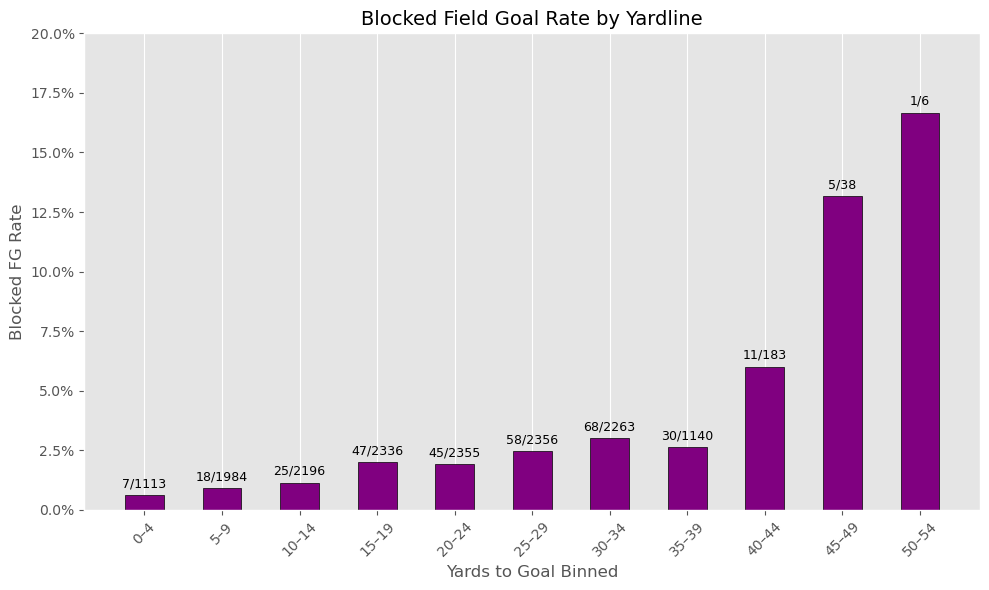

In [4]:
cpy = fg_attempts[['yardline_100', 'field_goal_result']].copy()

# Bin yardlines into 5-yard intervals
bins = np.arange(0, 60, 5)
cpy['yardline_bin'] = pd.cut(cpy['yardline_100'], bins=bins, right=False)

# Count total FG attempts and blocked FGs per bin
bin_totals = cpy.groupby('yardline_bin').size()
blocked_counts = cpy.query('field_goal_result == "blocked"').groupby('yardline_bin').size()

# Fill missing blocked counts with 0 for bins with no blocked FGs
blocked_counts = blocked_counts.reindex(bin_totals.index, fill_value=0)

# Calculate blocked rate
blocked_rate = blocked_counts / bin_totals

# Plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

bar_container = ax.bar(
    range(len(blocked_rate)), 
    blocked_rate.values, 
    width=0.5, 
    color='purple', 
    edgecolor='black'
)

# Add fraction labels on top of each bar
for i, (blocked, total, bar) in enumerate(zip(blocked_counts.values, bin_totals.values, bar_container)):
    label = f'{int(blocked)}/{int(total)}'
    ax.text(bar.get_x() + bar.get_width() / 2, 
            bar.get_height() + 0.002, 
            label, 
            ha='center', va='bottom', fontsize=9)

# Set custom x-axis labels
bin_labels = [f'{int(interval.left)}–{int(interval.right - 1)}' for interval in blocked_rate.index]
ax.set_xticks(range(len(bin_labels)))
ax.set_xticklabels(bin_labels, rotation=45)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.1f}%'))

ax.set_title('Blocked Field Goal Rate by Yardline', fontsize=14)
ax.set_xlabel('Yards to Goal Binned')
ax.set_ylabel('Blocked FG Rate')
ax.set_ylim(0, blocked_rate.max() * 1.2)
ax.grid(axis='y')
plt.tight_layout()
plt.show()


# ii. Selection bias in data?

In [5]:
fg_attempts.field_goal_result.unique()

array(['made', 'missed', 'blocked'], dtype=object)

# iii. FG Make Probability Model

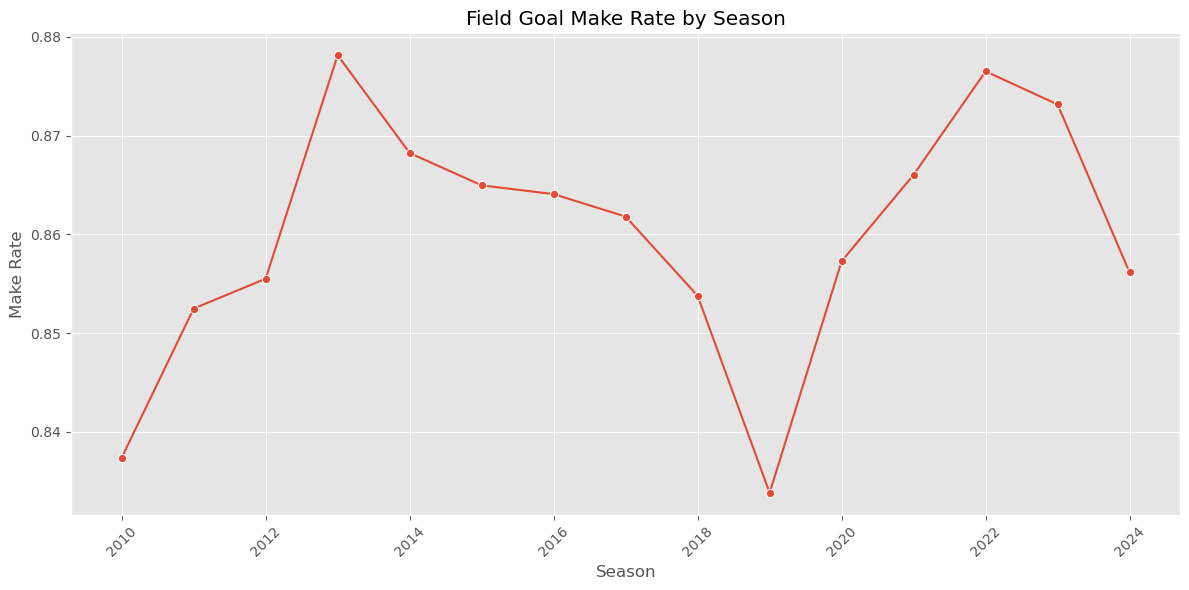

In [6]:
# plot the fg make rate by season
fg_make_rate = fg_attempts.groupby('season').field_goal_result.value_counts(normalize=True).unstack().fillna(0)
fg_make_rate['make_rate'] = fg_make_rate['made'] / (fg_make_rate['made'] + fg_make_rate['missed'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=fg_make_rate, x='season', y='make_rate', marker='o')
plt.title('Field Goal Make Rate by Season')
plt.xlabel('Season')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

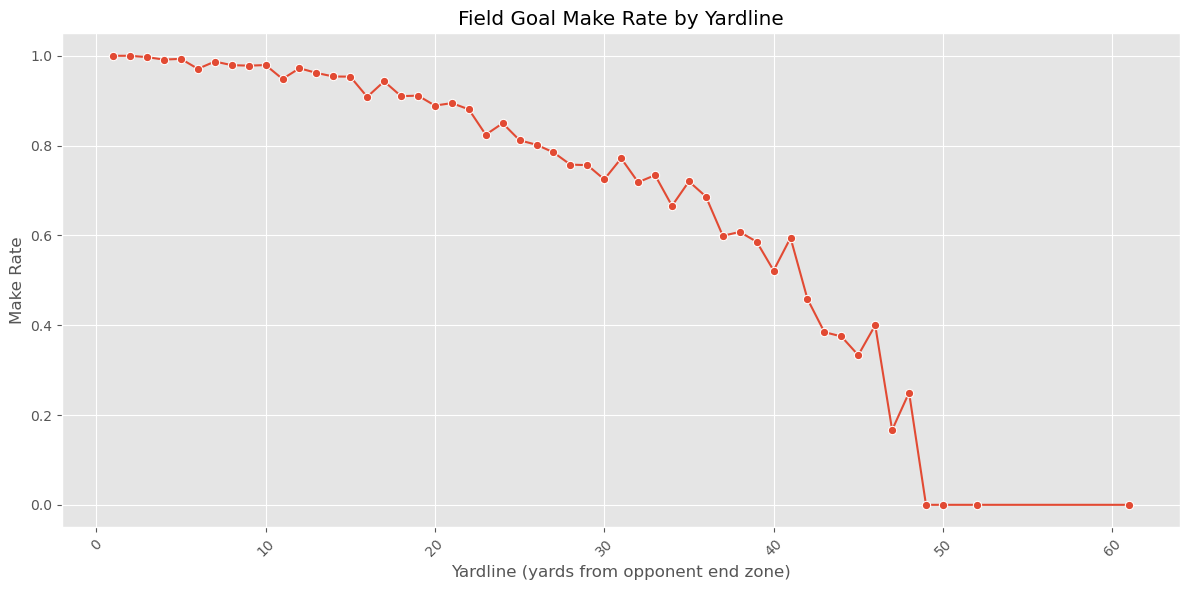

In [7]:
# plot fg make rate by yardline
fg_make_rate_yardline = fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True).unstack().fillna(0)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed'])
plt.figure(figsize=(12, 6))
sns.lineplot(data=fg_make_rate_yardline, x='yardline_100', y='make_rate', marker='o')
plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show() 

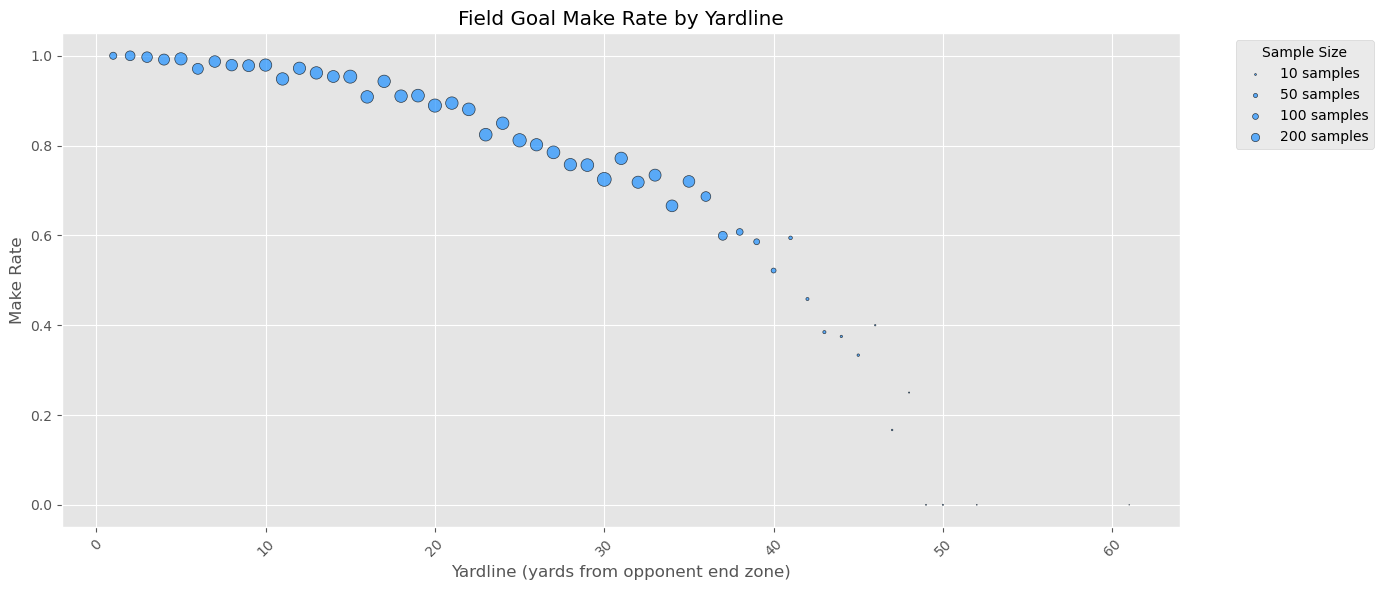

In [8]:
# Plot FG make rate by yardline, with marker size proportional to sample size and a legend for sample sizes

fg_make_rate_yardline = (
    fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True)
    .unstack().fillna(0)
)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (
    fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed']
)
fg_make_rate_yardline['sample_size'] = (
    fg_attempts.groupby('yardline_100').size()
)

plt.figure(figsize=(12, 6))
sizes = fg_make_rate_yardline['sample_size']
# Normalize sizes for plotting (adjust scale as needed)
size_scale = 100
marker_sizes = size_scale * (sizes / sizes.max())

scatter = plt.scatter(
    fg_make_rate_yardline.index,
    fg_make_rate_yardline['make_rate'],
    s=marker_sizes,
    alpha=0.7,
    c='dodgerblue',
    edgecolor='black',
    label='FG Make Rate'
)

plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Create a legend for sample sizes
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Choose representative sample sizes for legend
legend_sizes = [10, 50, 100, 200]
handles = [
    plt.scatter([], [], s=size_scale * (n / sizes.max()), color='dodgerblue', edgecolor='black', alpha=0.7,
                label=f'{n} samples')
    for n in legend_sizes
]
plt.legend(handles=handles, title='Sample Size', loc='upper right', bbox_to_anchor=(1.18, 1))

plt.show()

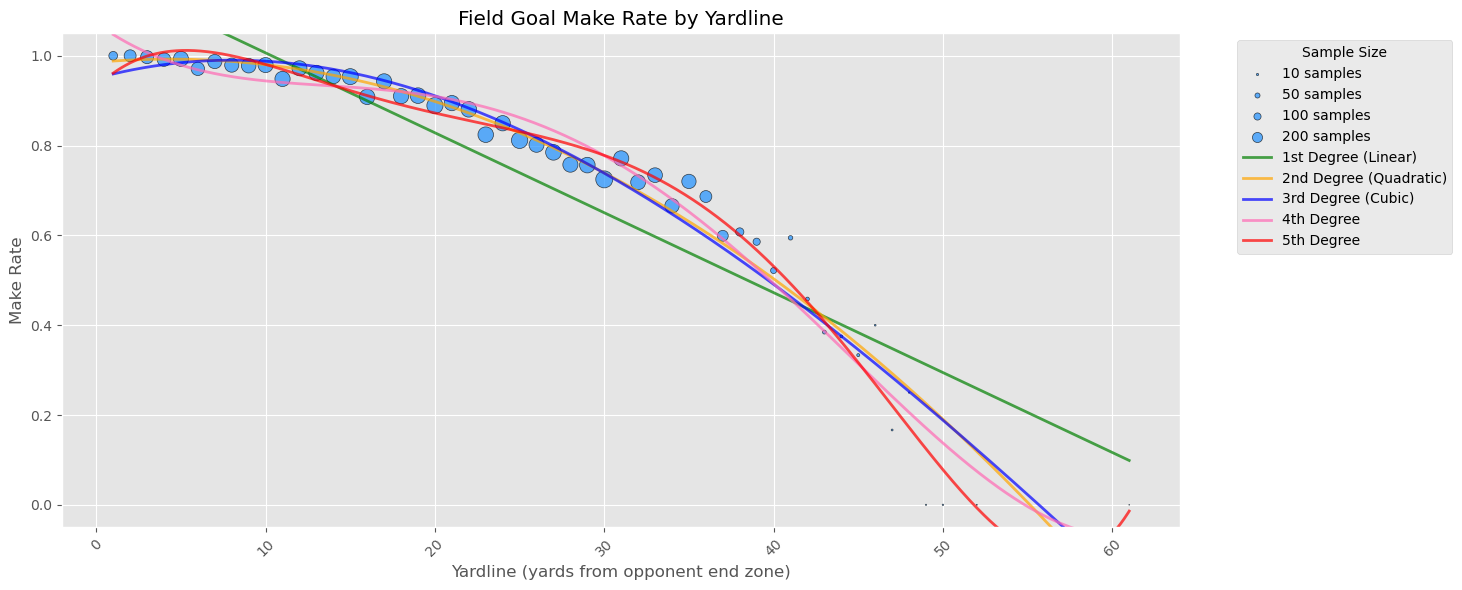

In [9]:
fg_make_rate_yardline = (
    fg_attempts.groupby('yardline_100').field_goal_result.value_counts(normalize=True)
    .unstack().fillna(0)
)
fg_make_rate_yardline['make_rate'] = fg_make_rate_yardline['made'] / (
    fg_make_rate_yardline['made'] + fg_make_rate_yardline['missed']
)
fg_make_rate_yardline['sample_size'] = (
    fg_attempts.groupby('yardline_100').size()
)

plt.figure(figsize=(12, 6))
sizes = fg_make_rate_yardline['sample_size']
size_scale = 150
marker_sizes = size_scale * (sizes / sizes.max())

scatter = plt.scatter(
    fg_make_rate_yardline.index,
    fg_make_rate_yardline['make_rate'],
    s=marker_sizes,
    alpha=0.7,
    c='dodgerblue',
    edgecolor='black',
    label='FG Make Rate'
)

x = np.array(fg_make_rate_yardline.index)
y = fg_make_rate_yardline['make_rate'].values
x_fit = np.linspace(x.min(), x.max(), 1000)

# Fit and plot polynomials of degree 1 to 5
colors = ['green', 'orange', 'blue', 'hotpink', 'red']
labels = [
    '1st Degree (Linear)',
    '2nd Degree (Quadratic)',
    '3rd Degree (Cubic)',
    '4th Degree',
    '5th Degree'
]
for deg, color, label in zip(range(1, 6), colors, labels):
    coeffs = np.polyfit(x, y, deg)
    poly = np.poly1d(coeffs)
    y_fit = poly(x_fit)
    plt.plot(x_fit, y_fit, color=color, linewidth=2, label=label, alpha=0.7)

plt.title('Field Goal Make Rate by Yardline')
plt.xlabel('Yardline (yards from opponent end zone)')
plt.ylabel('Make Rate')
plt.ylim(-.05, 1.05)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

import matplotlib.lines as mlines
legend_sizes = [10, 50, 100, 200]
handles = [
    plt.scatter([], [], s=size_scale * (n / sizes.max()), color='dodgerblue', edgecolor='black', alpha=0.7,
                label=f'{n} samples')
    for n in legend_sizes
]
# Add polynomial lines to legend
for color, label in zip(colors, labels):
    handles.append(mlines.Line2D([], [], color=color, linewidth=2, label=label, alpha=0.7))
plt.legend(handles=handles, title='Sample Size', loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

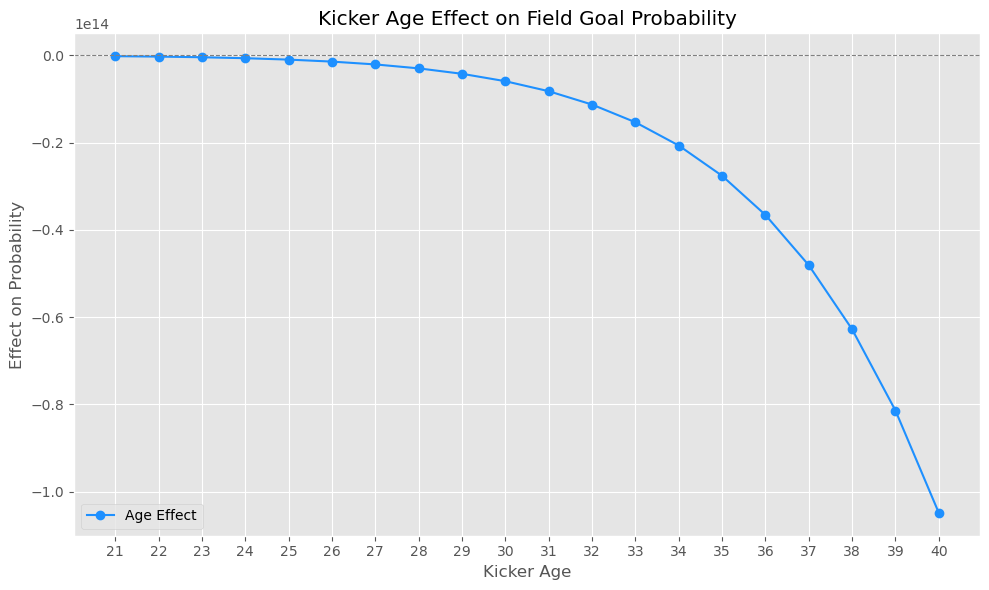

In [10]:
# plot this from ages 21-40: y = .1 * age - .05 * age^10
ages = np.arange(21, 41)
age_effect = 0.08 * ages - 0.01 * (ages **10)    
plt.figure(figsize=(10, 6))
plt.plot(ages, age_effect, marker='o', color='dodgerblue', label='Age Effect')
plt.title('Kicker Age Effect on Field Goal Probability')
plt.xlabel('Kicker Age')
plt.ylabel('Effect on Probability')
plt.xticks(ages)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
def evaluate_model(model, trace, y, coefficients):
    # Get posterior predictive samples
    with model:
        pp_samples = pm.sample_posterior_predictive(trace, var_names=['p'])

    # Calculate mean predicted probability across samples
    mean_p = pp_samples['posterior_predictive']['p'].mean(axis=1).mean(axis=0)

    # 1. Brier Score (lower is better)
    brier = brier_score_loss(y, mean_p)
    print(f"Brier Score: {brier:.4f}")

    # 2. AUC-ROC (higher is better, 0.5 = random)
    auc = roc_auc_score(y, mean_p)
    print(f"AUC-ROC: {auc:.4f}")

    # 3. LOOIC (from ArviZ)
    loo = az.loo(trace, pointwise=True)
    print("\nLOOIC Summary:")
    print(loo)

    # 4. Additional diagnostics
    print("\nModel Diagnostics:")
    print(az.summary(trace, var_names=coefficients,
                    kind='stats', round_to=2))

    # 5. Calibration check (expected vs actual)
    print("\nCalibration by Decile:")
    calibration_df = pd.DataFrame({'pred': mean_p, 'actual': y})
    calibration_df['decile'] = pd.qcut(calibration_df['pred'], q=10, duplicates='drop')
    print(calibration_df.groupby('decile').agg(actual_mean=('actual', 'mean'),
                                            pred_mean=('pred', 'mean'),
                                            count=('pred', 'count')))

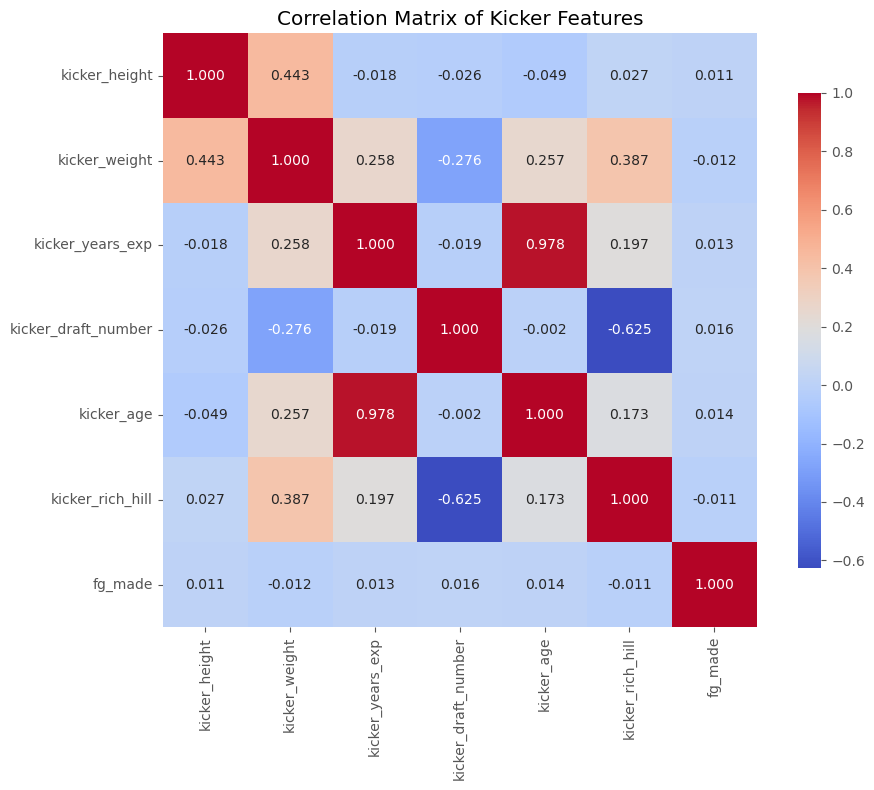

In [12]:
kicker_features = [
    'kicker_height', 'kicker_weight', 'kicker_years_exp', 'kicker_draft_number', 
    'kicker_age', 'kicker_rich_hill'
]
kicks = (
    fg_attempts
    .assign(
        fg_made = lambda x: x['field_goal_result'].eq('made').astype(int),
    )
    [kicker_features + ['fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = kicks.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Kicker Features')
plt.tight_layout()
plt.show()

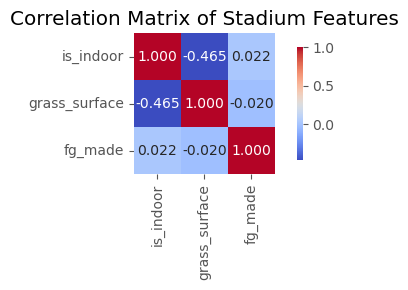

In [13]:
stadium_features = [
    'is_indoor', 'grass_surface'
]
kicks = (
    fg_attempts
    .assign(
        fg_made = lambda x: x['field_goal_result'].eq('made').astype(int),
    )
    [stadium_features + ['fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = kicks.corr()
plt.figure(figsize=(5, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Stadium Features')
plt.tight_layout()
plt.show()

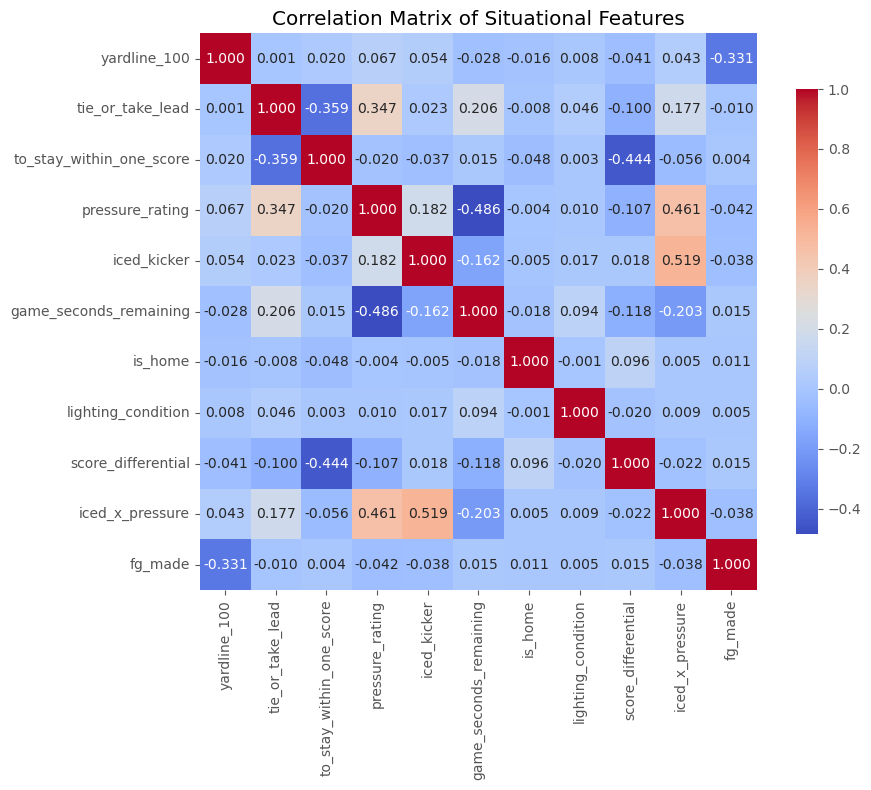

In [14]:
situational_features = [
    'yardline_100', 'tie_or_take_lead', 'to_stay_within_one_score', 'pressure_rating', 
    'iced_kicker', 'game_seconds_remaining', 'is_home', 'lighting_condition', 'score_differential'
]
kicks = (
    fg_attempts
    .assign(
        fg_made = lambda x: x['field_goal_result'].eq('made').astype(int),
        iced_x_pressure = lambda x: x['iced_kicker'] * x['pressure_rating']  # Interaction term
    )
    [situational_features + ['iced_x_pressure', 'fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = kicks.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Situational Features')
plt.tight_layout()
plt.show()


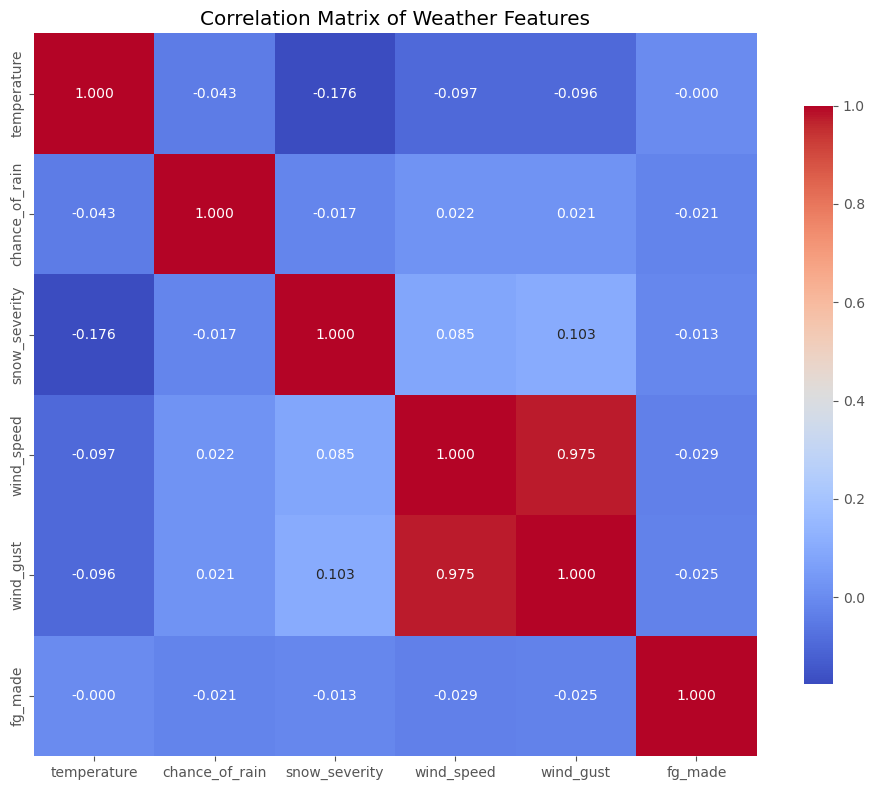

In [15]:
weather_features = [
    'temperature', 'chance_of_rain', 'snow_severity', 'wind_speed', 'wind_gust'
]
outdoor_kicks = (
    fg_attempts
    .query('is_indoor == 0') # Outdoor kicks only
    .assign(
        fg_made = lambda x: x['field_goal_result'].eq('made').astype(int),
    )
    [weather_features + ['fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = outdoor_kicks.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Weather Features')
plt.tight_layout()
plt.show()

$
z = \beta_0 + \\
\qquad \alpha_{\text{Kicker}_{i,j}} + \\
\qquad \gamma_{\text{Kicker}_{i,j}} \cdot \text{Yards to Goal}^2 + \\
\qquad \beta_2 \cdot \text{Is Home Team} + \\
\qquad \beta_3 \cdot \text{Time of Day} + \\
\qquad \beta_1 \cdot \text{Pressure Rating} + \\
\qquad \beta_4 \cdot \text{Iced Kicker} + \\
\qquad \beta_5 \cdot \text{Pressure Rating} \cdot \text{Iced Kicker} + \\
\qquad \beta_6 \cdot \text{Season} + \\
\qquad \gamma_{\text{Stadium}_k} \cdot \text{Wind Gusts} \cdot \mathbb{1}\{\text{Stadium}_k \text{ is outdoor}\} + \\
\qquad \beta_{7} \cdot \text{Wind Gusts} \cdot \text{Yards to Goal} \cdot \mathbb{1}\{\text{Outdoor Stadium}\} \\
\qquad \beta_8 \cdot \text{Temperature} \cdot \mathbb{1}\{\text{Outdoor Stadium}\} + \\
\qquad \beta_{9} \cdot \text{Temperature} \cdot \text{Yards to Goal} \cdot \mathbb{1}\{\text{Outdoor Stadium}\} + \\
\qquad \beta_{10} \cdot \text{Precipitation Chance} \cdot \mathbb{1}\{\text{Outdoor Stadium}\} + \\
\qquad \beta_{11} \cdot \text{Precipitation Chance} \cdot \text{Yards to Goal} \cdot \mathbb{1}\{\text{Outdoor Stadium}\} + \\
\qquad \beta_{12} \cdot \text{Snow Severity} \cdot \mathbb{1}\{\text{Outdoor Stadium}\} + \\
\qquad \beta_{13} \cdot \text{Snow Severity} \cdot \text{Yards to Goal} \cdot \mathbb{1}\{\text{Outdoor Stadium}\} + \\
\qquad \beta_{14} \cdot \text{Elevation} + \\
\qquad \beta_{15} \cdot \text{Elevation} \cdot \text{Yards to Goal} + \\
\\[2em]
\text{Where }\dots \\
\qquad\bullet \text{Kicker}_{i,j} \text{ is the } i^{\text{th}} \text{ kicker in his } j^{\text{th}} \text{ season} \\
\qquad\bullet \text{Stadium}_{k} \text{ is the } k^{\text{th}} \text{ stadium} \\
\qquad\bullet \text{Time of Day is one of daytime (0), dusk (1), nighttime (2)} \\
\qquad\bullet \mathbb{1}\{\text{Outdoor Stadium}\} = 1 \text{ if stadium is outdoor, 0 otherwise}
\\[2em]
P(Y = 1) = \text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
$

In [21]:
fg_attempts.stadium_id.nunique()

47

In [ ]:
# add elevation of each stadium
# add heckman model?

In [ ]:
# kicker_intercepts = fg_attempts[['kicker_player_name','kicker_player_id', 'season']].drop_duplicates()
# kicker_intercepts['kicker_season_idx'] = kicker_intercepts['kicker_player_id'].astype(str) + "_" + kicker_intercepts['season'].astype(str)

# kicker_intercepts = kicker_intercepts.merge(
#     pd.DataFrame({
#         'kicker_season_idx': kicker_intercepts['kicker_season_idx'],
#         'kicker_intercept': trace.posterior['kicker_intercepts'].mean(dim='chain').mean(axis=0).values
#     }), 
#     on='kicker_season_idx', 
#     how='left'
# )
# kicker_intercepts.head()

In [ ]:
# kicker_ytg_slopes = fg_attempts[['kicker_player_name','kicker_player_id', 'season']].drop_duplicates()
# kicker_ytg_slopes['kicker_season_idx'] = kicker_ytg_slopes['kicker_player_id'].astype(str) + "_" + kicker_ytg_slopes['season'].astype(str)
# kicker_ytg_slopes = kicker_ytg_slopes.merge(
#     pd.DataFrame({
#         'kicker_season_idx': kicker_ytg_slopes['kicker_season_idx'],
#         'kicker_intercept': trace.posterior['kicker_ytg_slopes'].mean(dim='chain').mean(axis=0).values
#     }), 
#     on='kicker_season_idx', 
#     how='left'
# )

# kicker_ytg_slopes.head()

In [22]:
# import numpy as np
# import pandas as pd
# import pymc as pm
# import xarray as xr
# from tqdm import tqdm

# def calculate_replacement_level_predictions(fg_attempts, trace, model, n_samples=1000):
#     """
#     Calculate replacement level predictions for all FG attempts in the dataset.
    
#     Args:
#         fg_attempts: DataFrame containing all FG attempts
#         trace: PyMC trace object from the fitted model
#         model: PyMC model object
#         n_samples: Number of posterior samples to use
        
#     Returns:
#         DataFrame with replacement level predictions and summary statistics
#     """
#     # Calculate replacement level features
#     replacement_age = fg_attempts.drop_duplicates(subset=['kicker_player_id', 'season']).kicker_age.median()
    
#     # Get kicker season indices for mapping
#     kicker_season_ids = fg_attempts["kicker_player_id"] + "_" + fg_attempts["season"].astype(str)
#     n_kicker_seasons = len(kicker_season_ids.unique())
    
#     # Get replacement level kicker parameters (10th percentile)
#     replacement_kicker_intercept = np.percentile(kicker_intercepts['kicker_intercept'].values, 10)
#     replacement_kicker_ytg_slope = np.percentile(kicker_ytg_slopes['kicker_intercept'].values, 10)
    
#     # Randomly select n_samples from the posterior (across all chains)
#     n_chains = trace.posterior.dims['chain']
#     n_draws = trace.posterior.dims['draw']
#     total_samples = n_chains * n_draws
    
#     # If we have fewer samples than requested, use all available
#     if total_samples < n_samples:
#         n_samples = total_samples
    
#     # Randomly select sample indices
#     sample_indices = np.random.choice(total_samples, size=n_samples, replace=False)
#     chain_indices = sample_indices // n_draws
#     draw_indices = sample_indices % n_draws
    
#     # Create replacement level data for posterior predictive sampling
#     with model:
#         # Create new input data with replacement level kicker features
#         # Kicker features (replacement level)
#         kicker_age_repl = np.full(len(fg_attempts), replacement_age)
#         scaler.fit(fg_attempts.drop_duplicates(['season','kicker_player_id'])['kicker_age'].values.reshape(-1, 1))
#         kicker_age_repl_scaled = scaler.transform(kicker_age_repl.reshape(-1, 1)).flatten()
#         scaler.fit((fg_attempts.drop_duplicates(['season','kicker_player_id'])['kicker_age'].values ** 10).reshape(-1, 1))
#         kicker_age_poly_repl_scaled = scaler.transform((kicker_age_repl.reshape(-1, 1) ** 10)).flatten()

#         # Situational features (keep original)
#         yards_to_goal = scaler.fit_transform(fg_attempts[['yardline_100']].values).flatten()
#         yards_to_goal_poly = scaler.fit_transform((fg_attempts[['yardline_100']].values ** 2)).flatten()
#         pressure_rating = scaler.fit_transform(fg_attempts[['pressure_rating']].values).flatten()
#         iced_kicker = scaler.fit_transform(fg_attempts[['iced_kicker']].values).flatten()
#         lighting_time_of_day = scaler.fit_transform(fg_attempts[['lighting_condition']].values).flatten()
#         is_home_team = scaler.fit_transform(fg_attempts['is_home'].values.reshape(-1,1)).flatten()

#         # Weather features (keep original)
#         is_outdoor = fg_attempts['is_indoor'].values == 0
#         temperature = np.zeros(len(fg_attempts))
#         temperature[is_outdoor] = scaler.fit_transform(fg_attempts.loc[is_outdoor, ['temperature']])[:, 0]
#         chance_of_rain = np.zeros(len(fg_attempts))
#         chance_of_rain[is_outdoor] = scaler.fit_transform(fg_attempts.loc[is_outdoor, ['chance_of_rain']])[:, 0]
#         snow_severity = np.zeros(len(fg_attempts))
#         snow_severity[is_outdoor] = scaler.fit_transform(fg_attempts.loc[is_outdoor, ['snow_severity']])[:, 0]
#         wind_gust = np.zeros(len(fg_attempts))
#         wind_gust[is_outdoor] = scaler.fit_transform(fg_attempts.loc[is_outdoor, ['wind_gust']])[:, 0]

#         # Stadium and season (keep original)
#         stadium_ids, stadium_idx = np.unique(fg_attempts['stadium_id'], return_inverse=True)
#         season = scaler.fit_transform(fg_attempts[['season']].values).flatten()

#         # Initialize array to store samples
#         p_repl_samples = np.zeros((n_samples, len(fg_attempts)))
        
#         # Sample from posterior for each selected sample
#         for i, (chain_idx, draw_idx) in tqdm(enumerate(zip(chain_indices, draw_indices)), total=n_samples, desc="Calculating Replacement Level Predictions"):
#             # Create replacement level logit for this sample
#             logit_p_repl = (
#                 trace.posterior['alpha'].isel(chain=chain_idx, draw=draw_idx).values
#                 + replacement_kicker_intercept  # replacement level intercept
#                 + replacement_kicker_ytg_slope * yards_to_goal  # replacement level slope
#                 + trace.posterior['beta_age'].isel(chain=chain_idx, draw=draw_idx).values * kicker_age_repl_scaled
#                 + trace.posterior['beta_age2'].isel(chain=chain_idx, draw=draw_idx).values * kicker_age_poly_repl_scaled
#                 + trace.posterior['beta_ytg2'].isel(chain=chain_idx, draw=draw_idx).values * yards_to_goal_poly
#                 + trace.posterior['beta_pressure_rating'].isel(chain=chain_idx, draw=draw_idx).values * pressure_rating
#                 + trace.posterior['beta_iced_kicker'].isel(chain=chain_idx, draw=draw_idx).values * iced_kicker
#                 + trace.posterior['beta_lighting_time_of_day'].isel(chain=chain_idx, draw=draw_idx).values * lighting_time_of_day
#                 + trace.posterior['beta_is_home_team'].isel(chain=chain_idx, draw=draw_idx).values * is_home_team
#                 + trace.posterior['beta_season'].isel(chain=chain_idx, draw=draw_idx).values * season
#                 + trace.posterior['stadium_intercepts'].isel(chain=chain_idx, draw=draw_idx).values[stadium_idx]
#                 + trace.posterior['beta_is_indoor'].isel(chain=chain_idx, draw=draw_idx).values * (1 - is_outdoor)
#             )
            
#             # Apply weather effects (conditional on outdoor)
#             outdoor_mask = is_outdoor.astype(int)
#             outdoor_stadium_ids = np.unique(fg_attempts.loc[is_outdoor, 'stadium_id'])
#             stadium_to_outdoor_idx = {sid: idx for idx, sid in enumerate(outdoor_stadium_ids)}
#             outdoor_stadium_idx = np.full(len(fg_attempts), -1, dtype=int)
            
#             for j in range(len(fg_attempts)):
#                 stadium_id = fg_attempts.iloc[j]['stadium_id']
#                 if stadium_id in stadium_to_outdoor_idx:
#                     outdoor_stadium_idx[j] = stadium_to_outdoor_idx[stadium_id]
            
#             # Add weather effects for outdoor games
#             weather_effect = (
#                 trace.posterior['beta_temperature_outdoor'].isel(chain=chain_idx, draw=draw_idx).values[outdoor_stadium_idx] * temperature +
#                 trace.posterior['beta_chance_of_rain_outdoor'].isel(chain=chain_idx, draw=draw_idx).values[outdoor_stadium_idx] * chance_of_rain +
#                 trace.posterior['beta_snow_severity_outdoor'].isel(chain=chain_idx, draw=draw_idx).values[outdoor_stadium_idx] * snow_severity +
#                 trace.posterior['beta_wind_gust_outdoor'].isel(chain=chain_idx, draw=draw_idx).values[outdoor_stadium_idx] * wind_gust
#             ) * outdoor_mask
            
#             logit_p_repl += weather_effect
            
#             # Calculate probabilities for this sample
#             p_repl_samples[i] = 1 / (1 + np.exp(-logit_p_repl))
        
#         # Calculate summary statistics across samples
#         repl_preds = fg_attempts.copy()
#         repl_preds['repl_fg_prob_mean'] = np.mean(p_repl_samples, axis=0)
#         repl_preds['repl_fg_prob_median'] = np.median(p_repl_samples, axis=0)
#         repl_preds['repl_fg_prob_std'] = np.std(p_repl_samples, axis=0)
#         repl_preds['repl_fg_prob_lower'] = np.percentile(p_repl_samples, 5, axis=0)
#         repl_preds['repl_fg_prob_upper'] = np.percentile(p_repl_samples, 95, axis=0)
        
#         return repl_preds

# # Calculate xFGPOR for all kicker seasons
# fg_attempts_not_blocked = (
#     fg_attempts.query('field_goal_result != "blocked"')
#     .copy()
#     .assign(
#         fg_made=lambda x: x['field_goal_result'].eq('made').astype(int)
#     )
# )
# repl_preds = calculate_replacement_level_predictions(fg_attempts_not_blocked, trace, model, n_samples=1000)

In [23]:
# def calculate_xfgpor(fg_attempts, trace, model, n_samples=1000):
#     """
#     Calculate expected FG percentage over replacement (xFGPOR) for each kicker season.
    
#     Args:
#         fg_attempts: DataFrame containing all FG attempts
#         trace: PyMC trace object from the fitted model
#         model: PyMC model object
#         n_samples: Number of posterior samples to use
        
#     Returns:
#         DataFrame with xFGPOR for each kicker season
#     """
    
#     # Calculate difference between actual and replacement level
#     fg_attempts['fg_prob_diff'] = (fg_attempts['fg_made'] - fg_attempts['repl_fg_prob_mean'])
#     fg_attempts['xFGPOR'] = 3 * fg_attempts['fg_prob_diff']
    
#     # Aggregate by kicker season
#     kicker_season_stats = (
#         fg_attempts
#         .groupby(['kicker_player_id', 'kicker_player_name', 'season'])
#         .agg(
#             attempts=('field_goal_result', 'count'),
#             fg_made=('fg_made', 'sum'),
#             fg_pct=('fg_made', 'mean'),
#             avg_repl_prob=('repl_fg_prob_mean', 'mean'),
#             xFGPOR=('xFGPOR', 'sum'),
#         )
#         .reset_index()
#     )
    
#     # Sort by xFGPOR
#     kicker_season_stats = kicker_season_stats.sort_values('xFGPOR', ascending=False)

#     return kicker_season_stats

# fg_attempts_replacement = (
#     pd.concat([fg_attempts_not_blocked, repl_preds.iloc[:,-5:]], axis=1)
# )
# kicker_season_xfgpor = calculate_xfgpor(fg_attempts_replacement, trace, model, n_samples=1000)